# 0. Project Goal

The data set includes online news contents, with its infomation including time/day, title, source, category and its upvotes/downvotes. To build a sucessful online platform, it is important to be able to infer contents' engagement.

Here, I will set the goal of the project to be: 
**Predicting the number of upvotes based on the given features.**

# 1. Dataset overview

## 1.A Load the data

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In the following, data can be direcly loaded from the tabular.

In [ ]:
#upload datafile
from google.colab import files
uploaded = files.upload()

In [ ]:
#change the data into dataframe format
df = pd.read_csv(io.BytesIO(uploaded['Reddit_worldnews.csv']))

## 1.B Datasets


In [ ]:
df.head(5)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   category      509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


- Dataset consisting of 8 variables.
- They have mixed data types: int64, object, boolean, object. Most of them have to be converted into usuful numerical values for ML ( or integer-encoded categorical values if using Light Gradient Boosting Machine package lightGBM which we will use). 
- There are no null values included, so there are no need for data cleaning.


## 1.C Understanding the data

The title looks like the headline of the news. We take a closer look at 'author' and 'category' variables.

In [ ]:
print('Author')
df.author.value_counts()

Author


davidreiss666     8897
anutensil         5730
DoremusJessup     5037
maxwellhill       4023
igeldard          4013
                  ... 
doug                 1
Mark9934             1
Jakubisko            1
0_0_0                1
crunchbangboom       1
Name: author, Length: 85838, dtype: int64

In [ ]:
print('Category')
df.category.value_counts()

Category


worldnews    509236
Name: category, dtype: int64

All samples have a category 'worldnews'. Through the online research, we can find that 'author' values are Reddit account names. Thus we can guess that the dataset contains data of news posts from [Reddit worldnews page](https://www.reddit.com/r/worldnews/).

## 1.D Target variable

### 1.D.1 Down_votes

In [ ]:
print('down_votes')
df.down_votes.value_counts()

down_votes


0    509236
Name: down_votes, dtype: int64

Variable 'down_votes' is 0 for all samples. Thus, we can omit this and aim to predict the 'up_vote' (target variable). It is possible that the variable 'up_vote' in this dataset is the number of upvotes minus the number of downvotes in Reddit as it is the number shown in its webpage.
This leave 'down_vote' here to 0.

### 1.D.2 Up_votes



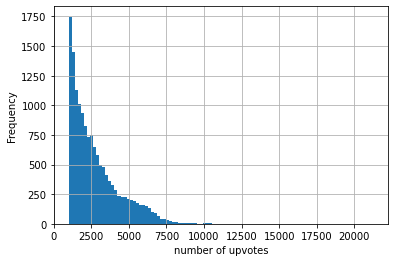

In [ ]:
df.up_votes[df.up_votes>1000].hist(bins = 100)
plt.xlabel('number of upvotes')
plt.ylabel('Frequency')
plt.show()

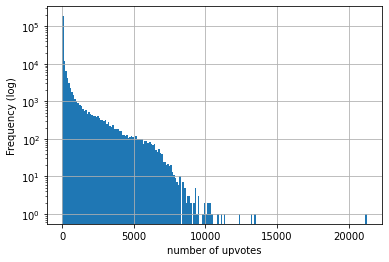

In [ ]:
df.up_votes[df.up_votes>5].hist(bins = 200, log=True)
plt.xlabel('number of upvotes')
plt.ylabel('Frequency (log)')
plt.show()

In general the distribution of upvotes are monotonically decreasing (with proper smoothing). The distribution is rather exponential decay in the low counts of upvotes, but but the decay slows down at upvotes around > 4000.

# 2. Feature Engineering

## 2.A Time Features

### 2.A.1 Features derived from 'time_created' & 'date_created'

We will use tree based model for ML.
Useful features that can be extracted from time features are, time over the day/week/year/the whole span of dataset.

- minute of the day (values from 0 to 23*60+59)
- day of the week (values from 0 to 6; Monday is 0 sunday is 6)
- day of the year (values from 1 to 366, including leap day)
- day over the whole dataset, starting from when the first sample was created (values from 0 to 3224(derived later))

Other feature
- holiday (True or False, following the US Federal Holiday)

First, we need to check if the variable 'date_created' was recorded in Coordinated Universal Time (UTC) or other time zones. We can check this by checking if the 'date_created' matches with the date of Unix timestamp 'time_created'.

In [ ]:
date_time = pd.to_datetime(df.time_created, unit='s').dt.date
date_date = pd.to_datetime(df.date_created, format='%Y-%m-%d').dt.date
df.loc[date_time != date_date]

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
343260,1423526400,2015-02-09,7,0,Christians in India want their own Christian c...,False,InternetOfficer,worldnews


In [ ]:
print('date of time_created: ', date_time[date_time!=date_date])
print('date of date_created: ', date_date[date_time!=date_date])

date of time_created:  343260    2015-02-10
Name: time_created, dtype: object
date of date_created:  343260    2015-02-09
Name: date_created, dtype: object


There is only one sample where the date of 'time_created' and 'date_created' do not match. This is due to the fact that the this sample was created exacly at 00:00:00. Thus there is nothing wrong with this discrepancy. Except for this one point, we can see that the date of both features matches each other.

From the above results, we can conclude that 'date_created' was recorded in UTC. From now on we can ignore the feature 'date_created' since the information can be extracted from variable 'time_created'.

According to the website [Similarweb](https://www.similarweb.com/website/reddit.com/#overview), 50% of its desktop traffic originates from the US, followed by 8% from the UK, and 8% from Canada. Also, U.S. consumers represent 76 percent of spending in the mobile app according to the article from [TensorFlow](https://sensortower.com/blog/reddit-app-install-record). Thus we can assume that the majority of the traffic comes from the US. Therefore we should change the time to one of the US time zones.

Using the data of 2014 Census etimates ([Quora post](https://qr.ae/pGpDNi)), we can calculate (done separately) the average 'time zone' in the US weighted by the population on each timezones to be UTC - 5.9, which is close to US Central Time. This timezone would be the best representative of the time zones in the US.


In [ ]:
#following takes into accout the day light saving time
df['time_ct'] = pd.to_datetime(df.time_created, unit='s', utc=True).dt.tz_convert('US/Central')

### 2.A.2 Time of the day
Next, let's see how the samples are distributed among time of the day.

In [ ]:
df_new = pd.DataFrame()

#Time of day
df_new['minute_of_day'] = df.time_ct.dt.minute + df.time_ct.dt.hour*60

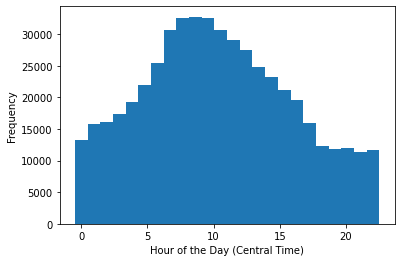

In [ ]:
df.time_ct.dt.hour.plot(kind='hist', bins=24, align='left')
plt.xlabel('Hour of the Day (Central Time)')
plt.show()

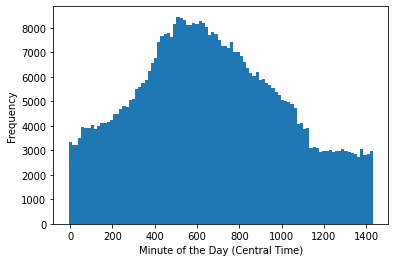

In [ ]:
df_new.minute_of_day.plot(kind='hist', bins=int(24*60/15), align='left')
plt.xlabel('Minute of the Day (Central Time)')
plt.show()

For tree based model, 'hour_of_day' won't be useful if there is 'minute_of_day' feature, since 'minute_of_day' is the detailed version (more bins) of the 'hour_of_day'. We will use 'minute_of_day' in our model. The distribution is unimodal but with plateau during the night. It is reassuring to see that 
-  The distribution is peaked at around 9am at US Central Time. It makes sense that Reddit users in the US start browsing Reddit after they wake up. 
- The somewhat constant frequency at night (~ 40% of the peak) can be explained by the Reddit traffic outside of the US spreading through the world.

### 2.A.3 Time of Week

In [ ]:
#Time of week
df_new['day_of_week'] = df.time_ct.dt.dayofweek

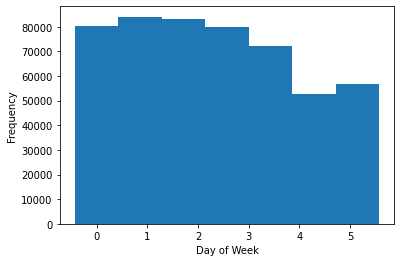

In [ ]:
df_new.day_of_week.plot(kind='hist', bins=7, align='left')
plt.xlabel('Day of Week')
plt.show()

There are less news created during the weekend (Saturday and Sunday).

### 2.A.4 Day of Year

In [ ]:
date_min = df.time_ct.dt.date.min()
date_max = df.time_ct.dt.date.max()

print('Min for time_created (CT): ', df.time_ct.min())
print('Max for time_created (CT): ', df.time_ct.max())

Min for time_created (CT):  2008-01-24 21:34:06-06:00
Max for time_created (CT):  2016-11-22 06:22:26-06:00


The dataset is spanned for around 9 years. Since the earliest time is January 2008 and the latest is Novermber 2016, some days of the year appear 9 times while others appear 8 times during this span.
One thing that needs to be careful here is that this differrence will be shown when we plot the histogram of samples over the year. There would be less frequency between Nov 22 to end of the year and Jan 1-23.

Thus the fact that there are less data samples in the end and the beginning of the year in the histogram doesn't necessary mean that there are actually less samples during the period unless it is more than 1/9 = 11% diffrenece compared to other time period.

Also, since there are also two leap years, 2012 and 2016 during the span, the last day of the year (day 365 out of 0-365) is expected to have very low samples when plotting the histogram.

Since our goal here is not about showing the correct frequencies of samples over the year, I will not take this factor into account when plotting the histogram.


In [ ]:
#Time of year (normalized)
df_new['day_of_year'] = df.time_ct.dt.dayofyear

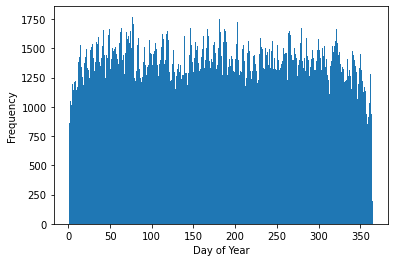

In [ ]:
df_new['day_of_year'].plot(kind='hist',bins=366, align='left')
plt.xlabel('Day of Year')
plt.show()

Zoom in the first and last 60 days.

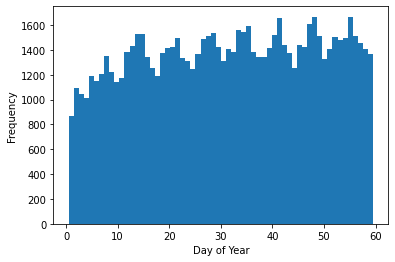

In [ ]:
df_new.day_of_year[df_new.day_of_year<61].plot(kind='hist',bins=60, align='left')
plt.xlabel('Day of Year')
plt.show()

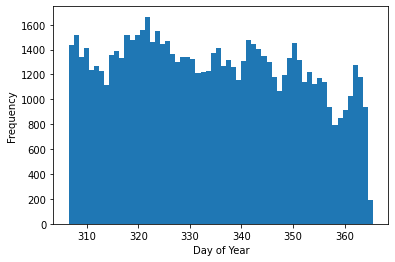

In [ ]:
df_new.day_of_year[df_new.day_of_year>= 366-60+1].plot(kind='hist',bins=60, align='left')
plt.xlabel('Day of Year')
plt.show()

The frequency of samples are declining in the end of the year and increasing in the beginning of the year, which makes sense. (This tendency is different from the effect described above.)

### 2.A.5 Through the whole span of the dataset

In [ ]:
#time throughout the dataset
df_new['days'] = (df.time_ct - df.time_ct.min()).dt.days

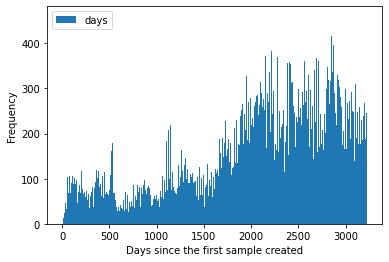

In [ ]:
df_new['days'].plot.hist(bins=df_new['days'].max()+1)
plt.xlabel('Days since the first sample created')
plt.legend()
plt.show()

Number of samples created per day in the last few years are higher than the early years in the dataset. It looks like Reddit got more popular in the recent years. This could contribute to more upvotes for the posts.

### 2.A.6 Holidays

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
holidays = USFederalHolidayCalendar().holidays(start=df.time_ct.dt.date.min(), end=df.time_ct.dt.date.max())
df_new['holiday'] = df['time_ct'].dt.date.astype('datetime64').isin(holidays).astype(int)

We will quickly calculate number of samples per the day of the week, and compare them with the case of the holiday.

In [ ]:
#number of weeks through the whole timespan
n_weeks = ((date_max - date_min)/7).days + ((date_max - date_min)/7).seconds/(60*60*24)
print(round(n_weeks), 'weeks between ', date_min, ' and ', date_max)

461 weeks between  2008-01-24  and  2016-11-22


In [ ]:
#number of samples per the day of the week
n_day_of_week = (df_new.day_of_week.value_counts()/n_weeks).sort_index()
print(n_day_of_week)

0    174.084032
1    182.427598
2    180.098606
3    173.667288
4    156.828218
5    114.667598
6    123.545117
Name: day_of_week, dtype: float64


Here 0 means Monday and 6 means Sunday.

In [ ]:
print('number of samples per holiday')
(df_new['holiday']).sum()/len(holidays)

number of samples per holiday


156.62790697674419

In average, number of news created in a holiday is more than in Saturday and Sunday,  but lower than in weekdays. Thus having a feature to tell if the sample was created on holiday is also useful.

## 2.B Features derived from 'title'

We will use the Natural Language Toolkit (NLTK) for analyzing the title. Features that can be derived from 'title' are:

Sentimenting scores using Sentiment Intensity Analyser (SIA)
- The probability of the sentiment to be positive (0 to 1, float)
- The probability of the sentiment to be negative (0 to 1, float)
- The probability of the sentiment to be neutural (0 to 1, float)
- The probability of the compunt sentimenting scores (-1 to 1, float)

Word Vectors derived from Doc2Vec
- vector 1 (float)
- vector 2 (float)

Others
- Readability : US grade level of education required to understand the text (float)
- word counts (int): number of words in the title
- written in uppercases (True or False).
- includes '!' (True or False)
- includes '?' (True or False)
- includes a video (True or False)
- includes a picture (True or False)

### 2.B.1 Sentimenting score features

We use Sentiment Intensity Analyser (SIA) to categorize the titles, and create four features:

- neg: nagative score 

In [ ]:
import nltk

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [ ]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

compound_list, neg_list, neu_list, pos_list = [], [], [], []
for i in range(len(df['title'])):
  if np.mod(i, 10000) ==0:
    print(i)
  pol_score = SIA().polarity_scores(df['title'][i])
  compound_list.append(pol_score['compound'])
  neg_list.append(pol_score['neg'])
  neu_list.append(pol_score['neu'])
  pos_list.append(pol_score['pos'])

In [ ]:
#Create a new dataframe storing sentimenting scores
df_sia = pd.DataFrame()
df_sia['neg'] = neg_list
df_sia['neu'] = neu_list
df_sia['pos'] = pos_list
df_sia['compound'] = compound_list

In [ ]:
df_sia.head()

,neg,neu,pos,compound
0,0.529,0.471,0.000,-0.6705
1,0.000,1.000,0.000,0.0000
2,0.000,1.000,0.000,0.0000
3,0.000,0.652,0.348,0.4939
4,0.362,0.638,0.000,-0.5267


In [ ]:
#append the SIA data to other features
df_new = pd.concat([df_new, df_sia], axis=1)

### 2.B.2 Readability and word count features

We determined the readability of each title using the textstat library.

To avoid U.S. being split into a word 'U' and 'S', and U.N. to 'U' and 'N', we change them to 'US' and 'UN' to preserve the words. We do this engineering since US (us, U.S., u.s.) is the most common word in the whole dataset (done separately using RegexpTokenizer, 10 most common words are:
[('us', 41740),
 ('china', 26397),
 ('says', 25432),
 ('new', 23388),
 ('syria', 19023),
 ('russia', 18766),
 ('world', 18091),
 ('police', 16654),
 ('government', 16305),
 ('israel', 16047)]).)
 U.N. is also one of the common words.)

Also, we get rid of [pics] and [video] from titles since they are not related to the title itself.

In [ ]:
!pip install textstat

In [ ]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import re
import textstat


In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')

readability_list = []
wordcount_list = []
tokens_all = []
tokens_list = []
title_length = []

for title in df['title']:
  #take out [video] and [pic]
  title = re.split('\[pics\]', title, 1)[0]
  title = re.split('\[video\]', title, 1)[0]
    
  #change U.N./U.S. to un/us
  title = title.replace('U.N.', 'UN') 
  title = title.replace('u.n.', 'un')  
  title = title.replace('U.S.', 'US')  
  title = title.replace('u.s.', 'us') 

  #tokenize
  tokenize0 = tokenizer.tokenize(title)
  
  #get number of words
  title_length.append(len(tokenize0))

  #get readability
  readability = textstat.flesch_kincaid_grade(title)
  readability_list.append(readability)

  #change to lower cases and get rid of stop words
  # tokenize = [t.lower() for t in tokenize0 if t.lower() not in stop_words]
  # tokens_list.append(tokenize)
  # tokens_all.extend(tokenize)

[]

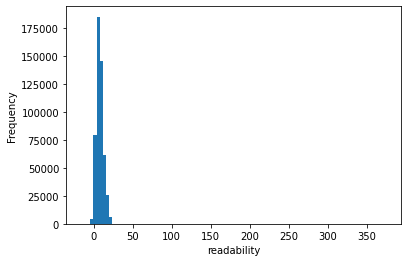

In [ ]:
plt.hist(readability_list, bins=100)
plt.ylabel('Frequency')
plt.xlabel('readability')
plt.plot()

In [ ]:
#add the readability feature
df_new['title_readability'] = readability_list
df_new['title_length'] = title_length

In [ ]:
df['title'][df_new['title_readability']>100]

1753      http://mentalmasturbator.com/2008/03/21/democr...
12255     Burma:+Buddhist+migrants+pressured+to+convert+...
19060       International+Condemnation;+Continuity+in+Burma
26874     http://www.comcast.net/data/fan/html/popup.htm...
36567                 australia-aborigine-cooked-prison-van
38705     xe-formally-blackwater-contractors-of-murder-k...
43102     http://www.dawn.com/wps/wcm/connect/dawn-conte...
43936              indymac-program-to-modify-mortgage-loans
79953     http://www.nypost.com/p/news/international/nuc...
244057    nsa-effort-pries-open-computers-not-connected-...
269984    Israel-says-it-will-no-longer-target-Palestini...
333678    http://www.independent.co.uk/news/uk/crime/pri...
347604    Exiled-Iranian-says-Tehran-hiding-secret-urani...
353331    egyptian-president-abdel-fatah-al-sissi-who-ta...
412781    French-President-Hollande-was-top-target-in-mu...
473250    https://www.theguardian.com/sport/2016/jun/28/...
Name: title, dtype: object

Titles with links and with '-' scored high readability.

### 2.B.2 Features derived from Vectorization (Doc2Vec)



Next we will derive features:
- 2 Word Vecors (float) derived from Vectorization


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.parsing.preprocessing import preprocess_string
from sklearn import utils
from tqdm import tqdm
import multiprocessing

class Doc2VecTransformer(BaseEstimator):
  def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self._model = None
    self.vector_size = vector_size
    self.workers = multiprocessing.cpu_count()

  def fit(self, df_x, df_y=None):
    tagged_x = [TaggedDocument(preprocess_string(row['title']), [index]) for index, row in df_x.iterrows()]
    model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers, min_count=1)
    for epoch in range(self.epochs):
      model.train(utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
      model.alpha -= self.learning_rate
      model.min_alpha = model.alpha
      self._model = model
    return self

  def transform(self, df_x):
    return np.asmatrix(np.array([self._model.infer_vector(preprocess_string(row['title'])) for index, row in df_x.iterrows()]))

In [ ]:
df_title = df['title'].to_frame()
d2v = Doc2VecTransformer(vector_size =2)
d2v.fit(df_title)
vector = transform(df_title)

vec1 = list(np.array(vectors)[:,0])
vec2 = list(np.array(vectors)[:,1])

df_vector = pd.DataFrame({'vec1':vec1, 'vec2':vec2})

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


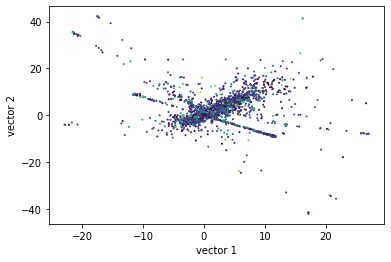

In [ ]:
plt.scatter(df_vector['vec1'], df_vector['vec2'], c=np.log(df['up_votes']), s=1)
plt.xlabel('vector 1')
plt.ylabel('vector 2')
plt.show()

Ideally we want data samples to be clustered with similar color (similar up votes values), but we will add these word vectors as features. If we have more time, we could map the titles into larger dimensions, (larger number of word vecters). Then we could implement the Principal Component Analysis based on the upvotes to lower the dimension. (However, this takes a lot of time).

Add these two vectors as features

In [ ]:
# train model
df_new = pd.concat([df_new, df_vector], axis=1)

### 2.B.3 Other features from 'title'

Add a feature to tell if the whole title
 - is written in uppercases (0(False) or 1(True)).
 - includes '!' (0 or 1)
 - includes '?' (0 or 1)
 - includes a video (0 or 1)
 - includes a picture (0 or 1)

In [ ]:
title_upper, title_exclm, title_question = [], [], []
title_pic, title_video = [], []

for title in df['title']:
  title_upper.append(int(title.isupper()))
  title_exclm.append(int('!' in title))
  title_question.append(int('?' in title))
  title_pic.append(int('[video]' in title))
  title_video.append(int('[pic]' in title))

df_new['title_uppercase'] = title_upper
df_new['title_exclm'] = title_exclm
df_new['title_question'] = title_question
df_new['title_pic'] = title_pic
df_new['title_video'] = title_video

In [ ]:
print('Examples of titles written in all upper cases')
df['title'][df_new['title_uppercase']==1].head(3)

Examples of titles written in all upper cases


78        INTERNET DAMAGED CABLES TO BE FIXED BY FEB 10
97     AL QAEDA LEADERS ARE NOT OPERATING FROM PAKISTAN
577                                           CHCNK OUT
Name: title, dtype: object

In [ ]:
print('Examples of titles including an exclamation mark')
df['title'][df_new['title_exclm']==1].head(3)


Examples of titles including an exclamation mark


5      Hay presto! Farmer unveils the  illegal  mock-...
144            BBC cover Anonymous Scientology Protests!
192    Go and see this exhibition if you are from Lon...
Name: title, dtype: object

In [ ]:
print('Examples of titles including an question mark')
df['title'][df_new['title_question']==1].head(3)

Examples of titles including an question mark


20           Possible  Guantanamo  on UK soil?  [video]
30       What the hell is going on in the Eastern Cape?
46    Who cuts undersea cables in the Middle East? A...
Name: title, dtype: object

## 2.C Author feature

Take a look at the distribution of authors.

In [ ]:
print('Number of samples by the author ')
author_counts = df.author.value_counts()
print(author_counts[:5])

Number of samples by the author 
davidreiss666    8897
anutensil        5730
DoremusJessup    5037
maxwellhill      4023
igeldard         4013
Name: author, dtype: int64


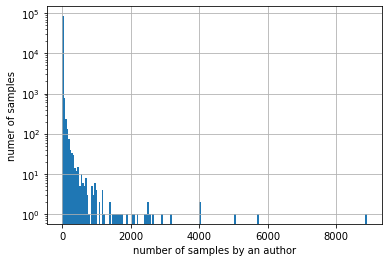

In [ ]:
author_counts.hist(bins=200, log=True)
plt.xlabel('number of samples by an author')
plt.ylabel('numer of samples')
plt.show()

First we change the name of the author who has less than 5 datapoints to 'anonymous'. We don't need to identify these individuals since in the tree based ML model, we will likely to limit the number of data in each leave to be >=5.

In [ ]:
n_authors = len(author_counts)
print('number of authors: ', n_authors)
print('number of authors with less than 5 samples: ', len(author_counts[author_counts<5]))

number of authors:  12000
number of authors with less than 5 samples:  0


In [ ]:
mask = df['author'].isin(author_counts[author_counts > 4].index)
#change author name with equal or less than 5 samples to 'anonymous'
df['author'][~mask] = 'anonymous'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Here we convert the author variable shown as a name (object) to integer, to create an integer-encoded categorical feature.

In [ ]:
#create a map from author name to index
authors_list = list(author_counts.index)
map_author = dict(zip(list(author_counts.index), list(range(n_authors))))


In [ ]:
import category_encoders as ce
# create object of Ordinalencoding
encoder= ce.OrdinalEncoder(cols=['author'],return_df=True, mapping=[{'col':'author',
'mapping':map_author}])

#fit and transform train data 
df_auhtor_transformed = encoder.fit_transform(df['author'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Now the author variable was changed to an integer-encoded categorical feature.

In [ ]:
pd.concat([df['author'], df_auhtor_transformed], axis=1).head(5)

,author,author
0,polar,1301
1,polar,1301
2,polar,1301
3,anonymous,0
4,anonymous,0


In [ ]:
#add this feature to the dataframe df_new
df_new = pd.concat([df_new, df_auhtor_transformed], axis=1)

## 2.D Other features

The remaining variables in the dataset not in use are 'over_18' and 'category'. Since 'category' is 'worldnews' for all samples, so it is useless as a feature. Variable 'over_18' is already shown in boolean, so it can be readily used as a feature.

In [ ]:
df_new['over_18'] = df['over_18'].astype(int)

Now all the features are created. Now we have 20 features

In [ ]:
df_new.head()

,minute_of_day,day_of_week,day_of_year,days,holiday,neg,neu,pos,compound,title_readability,title_length,vec1,vec2,title_uppercase,title_exclm,title_question,title_pic,title_video,over_18,author
0,1294,3,24,0,0,0.529,0.471,0.000,-0.6705,-1.9,5,-0.247142,0.151910,0,0,0,0,0,0,1301
1,1294,3,24,0,0,0.000,1.000,0.000,0.0000,13.1,4,0.140650,-0.151306,0,0,0,0,0,0,1301
2,1302,3,24,0,0,0.000,1.000,0.000,0.0000,2.1,6,0.135792,-0.059465,0,0,0,0,0,0,1301
3,1314,3,24,0,0,0.000,0.652,0.348,0.4939,3.7,8,-0.013305,0.043041,0,0,0,0,0,0,0
4,565,4,25,0,0,0.362,0.638,0.000,-0.5267,6.0,8,0.025937,0.065162,0,0,0,0,0,0,0


# 3. Model Training

## 3.A Allocation of test set

We will leave 10% of the data as a validation set, and use other 10% for test set. In general we will use k-fold (5-fold) cross validation for tuning the hyperparameters (done separately), but leave the validation set for early stopping.

In [ ]:
from sklearn.model_selection import train_test_split

#change data to numpy array
X = df_new
y = df['up_votes']
#split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)
#split the training set further into the traiing set and the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state =2)

In [ ]:
print('Training set sample: ', y_train.size)
print('Validation set sample: ', y_val.size)
print('Test set sample: ', y_test.size)

Training set sample:  407388
Validation set sample:  50924
Test set sample:  50924


## 3.B Baseline: mean
- I will set the mean of the sale rates as a baseline. The ML models should outperform this baseline.
- Here track the performance by defining the regression loss with mean absolute error since the distribution of up_votes is skewed.

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
#baaseline for training set
y_pred_base = np.mean(y_train)*np.ones(y_train.shape)
mae = mean_absolute_error(y_pred_base, y_train)
print('Training set loss (MAE):%.5f' % mae)

#baseline for test set
y_pred_val_base = np.mean(y_val)*np.ones(y_val.shape)
mae = mean_absolute_error(y_pred_val_base, y_val)
print('Validation set loss (MAE):%.5f' % mae)

#baseline for test set
y_pred_test_base = np.mean(y_test)*np.ones(y_test.shape)
mae = mean_absolute_error(y_pred_test_base, y_test)
print('Test set loss (MAE):%.5f' % mae)


Training set loss (MAE):186.15503
Validation set loss (MAE):189.03636
Test set loss (MAE):172.35833


## 3.D model: LightGBM - Gradient Boosted Trees

Next we employ GBDT with MSE as objective function. We employ early-stopping to avoidoverfitting due to adding more trees, and we assess tune hyperparameters using gridsearch (done separately).

In [ ]:
!pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 1.5MB 5.5MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
    Running setup.py install for lightgbm ... done


In [ ]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

Following hypterparameters have been tuned using the cross validation (5-cross) (done separately)

In [ ]:
d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_val, label=y_val)
params = {
    'objective':'regression_l1',
    'boosting':'gbdt',
    'verbose': 1,
    'seed': 33,
    'early_stopping_rounds':5,
    'learning_rate':0.5,
    'num_iterations':50,
    'num_leaves':100,
    'min_data_in_leaf':50,
    'min_child_weight':0,
    'min_split_gain':0,
    'n_estimator':10,
    'stratified': False,
    'device':'gpu',
    'min_data_in_bin':86
}


#With Catgeorical Features
cate_features_name = ['holiday', 'title_uppercase',	'title_exclm',	'title_question',	'title_pic', 'title_video',	'author',	'over_18']
model = lgb.train(params, d_train, categorical_feature = cate_features_name, valid_sets = d_val)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['author', 'holiday', 'over_18', 'title_exclm', 'title_pic', 'title_question', 'title_uppercase', 'title_video']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: stratified
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: stratified
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2749
[LightGBM] [Info] Number of data points in the train set: 407388, number of used features: 19
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (4.66 MB) transferred to GPU in 0.007099 secs. 1 sparse feature groups
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: stratified
[LightGBM] [Info] Start training from score 5.000000
[1]	valid_0's l1: 112.546
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 112.372
[

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[4]	valid_0's l1: 112.307
[5]	valid_0's l1: 112.264
[6]	valid_0's l1: 112.236
[7]	valid_0's l1: 112.235
[8]	valid_0's l1: 112.244
[9]	valid_0's l1: 112.233
[10]	valid_0's l1: 112.228
[11]	valid_0's l1: 112.229
[12]	valid_0's l1: 112.23
[13]	valid_0's l1: 112.225
[14]	valid_0's l1: 112.225
[15]	valid_0's l1: 112.225
[16]	valid_0's l1: 112.224
[17]	valid_0's l1: 112.228
[18]	valid_0's l1: 112.221
[19]	valid_0's l1: 112.222
[20]	valid_0's l1: 112.223
[21]	valid_0's l1: 112.222
[22]	valid_0's l1: 112.223
[23]	valid_0's l1: 112.223
Early stopping, best iteration is:
[18]	valid_0's l1: 112.221


Predict the upvote using the training set and the test set

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [ ]:
#Mean Absolute error (MAE) for training set
mae = mean_absolute_error(y_pred_train, y_train)
print('Training set loss (MAE):%.3f' % mae)

#Mean Absolute error (MAE) for validation set
mae = mean_absolute_error(y_pred_val, y_val)
print('Validation set loss (MAE):%.3f' % mae)

#Mean Absolute error (MAE) for test set
mae = mean_absolute_error(y_pred_test, y_test)
print('Test set loss (MAE):%.3f' % mae)

Training set loss (MAE):110.491
Validation set loss (MAE):112.221
Test set loss (MAE):102.985


The loss with Gradient Boost method is much smaller than with beaseline with 186 on training set and 172 with test set.

### Prediction error

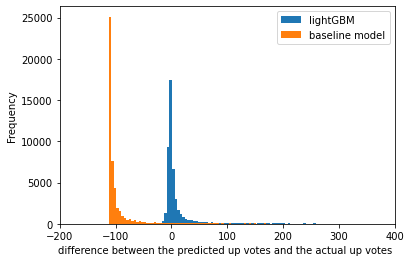

In [ ]:
error_gb_train = y_train - y_pred_train
error_gb_test = y_test - y_pred_test
error_baseline = y_test -y.mean()

plt.hist(error_gb_test, bins=3000, label='lightGBM')
plt.hist(error_baseline, bins=3000, label='baseline model')
plt.ylabel('Frequency')
plt.xlabel('difference between the predicted up votes and the actual up votes ')
plt.xlim(-200,400)
plt.legend()
plt.show()

Since the distribution of the up_votes are not symmetric, the peak of the distribution of the error for baseline (gloabl mean) is off from 0 even thought its mean is ~ 0. However, the predicted upvotes modeled by the Gradient Boost is distributed around 0. This results into much smaller mean abolute error (better prediction) than the baseline.

In [ ]:
print('Gradient Boost')
percent_u100_test = len(error_gb_test[abs(error_gb_test)<=100])/len(y_test)*100
print(' Percentage of estimated upvotes within +-100 of true upvotes:%.2f' % percent_u100_test)

print('Baseline: global mean')
percent_u100_baseline = len(error_baseline[abs(error_baseline)<=100])/len(y_test)*100
print(' Percentage of estimated upvotes within +-100 of true upvotes:%.2f' % percent_u100_baseline)


print('Gradient Boost')
percent_u100_test = len(error_gb_test[abs(error_gb_test)<=50])/len(y_test)*100
print(' Percentage of estimated upvotes within +-50 of true upvotes:%.2f' % percent_u100_test)

print('Baseline: global mean')
percent_u100_baseline = len(error_baseline[abs(error_baseline)<=50])/len(y_test)*100
print(' Percentage of estimated upvotes within +-50 of true upvotes:%.2f' % percent_u100_baseline)


Gradient Boost
 Percentage of estimated upvotes within +-100 of true upvotes:90.56
Baseline: global mean
 Percentage of estimated upvotes within +-100 of true upvotes:21.60
Gradient Boost
 Percentage of estimated upvotes within +-50 of true upvotes:87.23
Baseline: global mean
 Percentage of estimated upvotes within +-50 of true upvotes:4.27


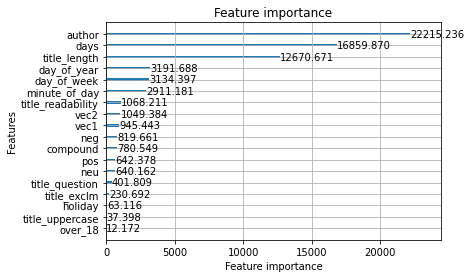

In [ ]:
lgb.plot_importance(model, importance_type='gain')